In [1]:
##source("../scripts/nhpf.fun.R")
library(Seurat)
library(dplyr)
library(ggplot2)

genelist <- readRDS(file = paste0("./load_files/Bulk_DEseq2_genes_v2.rds"))
load(file = "./load_files/InVivo_seurat_data_v3.Rdata")
## early, late

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Write out the DE genes into a table
max_len <- max(sapply(genelist, length))
equal_len_list <- lapply(genelist, function(x){
    if (length(x) < max_len){
        y <- c(x, rep("", max_len - length(x)))
    } else {
        y <- x
    }
    return(y)
})
sapply(genelist, length)
sapply(equal_len_list, length)
sapply(equal_len_list, tail)
equal_len_tb <- as.data.frame(equal_len_list)
write.table(equal_len_tb, file = "./load_files/Bulk_DEGs_v2.txt", 
            sep = "\t", quote = FALSE, col.names = TRUE, row.names = FALSE)

E42_FC_early  E42_FC_late   E42_FC_mid E42_OC_early  E42_OC_late   E42_OC_mid 
        1765         1676         1407          271          443          316 
E77_FC_early  E77_FC_late   E77_FC_mid E77_OC_early  E77_OC_late   E77_OC_mid 
         897          503          598          231          281          161

E42_FC_early  E42_FC_late   E42_FC_mid E42_OC_early  E42_OC_late   E42_OC_mid 
        1765         1765         1765         1765         1765         1765 
E77_FC_early  E77_FC_late   E77_FC_mid E77_OC_early  E77_OC_late   E77_OC_mid 
        1765         1765         1765         1765         1765         1765

E42_FC_early,E42_FC_late,E42_FC_mid,E42_OC_early,E42_OC_late,E42_OC_mid,E77_FC_early,E77_FC_late,E77_FC_mid,E77_OC_early,E77_OC_late,E77_OC_mid
REP15,,,,,,,,,,,
CHRNE,,,,,,,,,,,
LOC114674100,,,,,,,,,,,
NRSN2,,,,,,,,,,,
LOC114677452,,,,,,,,,,,
KLK6,,,,,,,,,,,


In [3]:
## Set some parameters
xaxis_limits <- c(-0.9, 0.9)
yaxis_limits <- c(0, 40)

In [4]:
## Functions used in this analysis
ExtractFullRegionMarkers <- function(object, ident.1 = "FC", ident.2 = "OC"){
    Idents(object) <- "region"
    res <- FindMarkers(object, ident.1 = ident.1, ident.2 = ident.2, 
                        max.cells.per.ident = 1000, only.pos = TRUE, 
                        logfc.threshold = 0.05)
    de_genes <- rownames(res)[res$p_val_adj <= 0.05 & res$pct.1 >= 0.05 & res$avg_log2FC > 0.05]
    return(de_genes)
}



## Functions to do in vivo DE
FindRegionMarkers <- function(object, genes_use, x_range = c(-0.9, 0.9), y_range = c(0, 40)){
    Idents(object) <- "region"
    ## only.pos has to be set to FALSE, so that the genes of res1 and res2 are the same
    ## Also, it can gives both negative and positive FCs
    res1 <- FindMarkers(object, ident.1 = "FC", ident.2 = "OC", 
                        max.cells.per.ident = 1000, only.pos = FALSE, 
                        features = genes_use, min.pct = -1, logfc.threshold = -1)

    res2 <- FindMarkers(object, ident.1 = "OC", ident.2 = "FC", 
                        max.cells.per.ident = 1000, only.pos = FALSE, 
                        features = genes_use, min.pct = -1, logfc.threshold = -1)
    
    ## check the consistency of genes
    if (length(setdiff(rownames(res1), rownames(res2))) > 0 | length(setdiff(rownames(res2), rownames(res1))) > 0){
        stop("The genes in res1 and res2 are not the same")
    }
    
    res2 <- res2[rownames(res1), , drop = FALSE]

    df <- data.frame(gene = rownames(res1),
                    pct.fc = res1$pct.1,
                    pct.oc = res1$pct.2,
                    p_val_adj = res1$p_val_adj,
                    log2fc.fc = res1$avg_log2FC, ##FC/OC fold changes
                    log2fc.oc = res2$avg_log2FC, ##OC/FC fold changes
                    stringsAsFactors = FALSE)
    
    df <- df %>%
                    mutate(log2fc.fc = MinMax(log2fc.fc, min = x_range[1], max = x_range[2])) %>%
                    mutate(mlogp = -log10(p_val_adj)) %>%
                    mutate(mlogp = MinMax(mlogp, min = y_range[1], max = y_range[2]))
    return(df)
}


## Extract the regional DEGs for NSCs
ExtractType1DEGs <- function(res, nsc_cls){
    fc_genes <- res$gene[(res$p_val_adj <= 0.05 & res$pct.fc >= 0.05 & res$log2fc.fc > 0) & 
                         res$cluster %in% nsc_cls] %>% 
                unique()
    oc_genes <- res$gene[(res$p_val_adj <= 0.05 & res$pct.oc >= 0.05 & res$log2fc.oc > 0) & 
                         res$cluster %in% nsc_cls] %>% 
                unique()
    return(list(FC = fc_genes, OC = oc_genes))
}



## plot dot plot highlight consistent regional enrichment in NSCs for both in vitro and in vivo
PlotDot <- function(data, frontal_label, occipital_label, x_range = c(-0.9, 0.9), y_range = c(0, 40)){
    ## preprocess the data based on the labeled genes
    data$gtype <- sapply(data$gene, function(x) 
                            case_when(x %in% frontal_label ~ "FC",
                                        x %in% occipital_label ~ "OC",
                                        TRUE ~ "bg")
                            )
    data$color <- c(FC = "#FF420E", OC = "#89DA59", bg = "#D3D3D3")[data$gtype]
    data$size <- c(FC = 4, OC = 4, bg = 2)[data$gtype]
    data$label <- ifelse(data$gene %in% union(frontal_label, occipital_label), data$gene, NA)

    set.seed(42)
    p <- ggplot(data, aes(x = log2fc.fc, y = mlogp, color = color, size = size, label = label)) +
                ggrastr::rasterise(geom_point(alpha = 0.7, shape = 16), dpi = 300, scale = 1) +
                ggrepel::geom_text_repel(max.overlaps = Inf) +
                geom_hline(yintercept = -log10(0.05), linetype = "dashed", linewidth = 1) +
                scale_color_identity() +
                scale_size_identity() +
                scale_x_continuous(limits = x_range) +
                scale_y_continuous(limits = y_range) +
                theme_bw() +
                theme(panel.grid.major = element_blank(), 
                      panel.grid.minor = element_blank(), 
                      legend.position = "none")
    return(p)
}

In [5]:
names(genelist)

[1] "E42_FC_early" "E42_FC_late"  "E42_FC_mid"   "E42_OC_early" "E42_OC_late" 
 [6] "E42_OC_mid"   "E77_FC_early" "E77_FC_late"  "E77_FC_mid"   "E77_OC_early"
[11] "E77_OC_late"  "E77_OC_mid"

In [6]:
ag <- "E42"
## Here type-1 genes are genes that are region-specific in NSCs
type1_genes <- lapply(c("FC", "OC"), function(reg) genelist[[paste0(ag, "_", reg, "_early")]]) %>%
    setNames(., c("FC", "OC"))


## Check the regional enrichment of all these genes
genes <- unlist(type1_genes) %>% unique() %>%
            intersect(., rownames(early))

early$subcls_abbr <- gsub("dorsal NSC", "NSC", early$subclass) %>%
                        gsub("Excitatory neurons", "ExN", .)

deres <- FindRegionMarkers(object = subset(early, subcls_abbr %in% "NSC"), genes_use = genes,
                          x_range = xaxis_limits, y_range = yaxis_limits) %>%
            mutate(cluster = "NSC")

In [7]:
## Get the in vitro FC (Anterior/Frontal versus Posterior/Occipital) at timepoints 1-3
load(file = paste0("./load_files/NSC_invitro_dorsal_bulk_RNA.Rdata"))
## subcount, subrpkm, submeta
logrpkm <- log2(subrpkm + 1)
submeta$period <- sapply(submeta$days, function(x){
    p <- case_when(x <= 3 ~ "early", 
                    x >3 & x < 8 ~ "mid",
                    x >= 8 ~ "late")
    return(p)
    })



fc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "early" & 
                               submeta$region %in% "FC"]
oc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "early" & 
                               submeta$region %in% "OC"]
## inconsistent regional enrichment between in vitro and in vivo
subrpkm[c("TTR", "NR2F2", "IGSF21", "SAT1", "DCT"), c(fc.points, oc.points)] 

,RM_1F_42,RM_2F_42,RM_3F_42,RM_1C_42,RM_2C_42,RM_3C_42
TTR,0.9483,1.7233,0.5025,0.0801,0.0416,0.0429
NR2F2,52.8437,50.5304,29.3751,5.4269,5.9742,7.6395
IGSF21,0.5360,0.3437,1.4196,0.1042,0.1216,0.3349
SAT1,44.3050,52.9528,58.7508,186.7626,160.2432,96.6129
DCT,0.3508,0.2929,0.6777,2.4745,3.4934,3.0557


Warning message:
“Removed 1983 rows containing missing values (`geom_text_repel()`).”


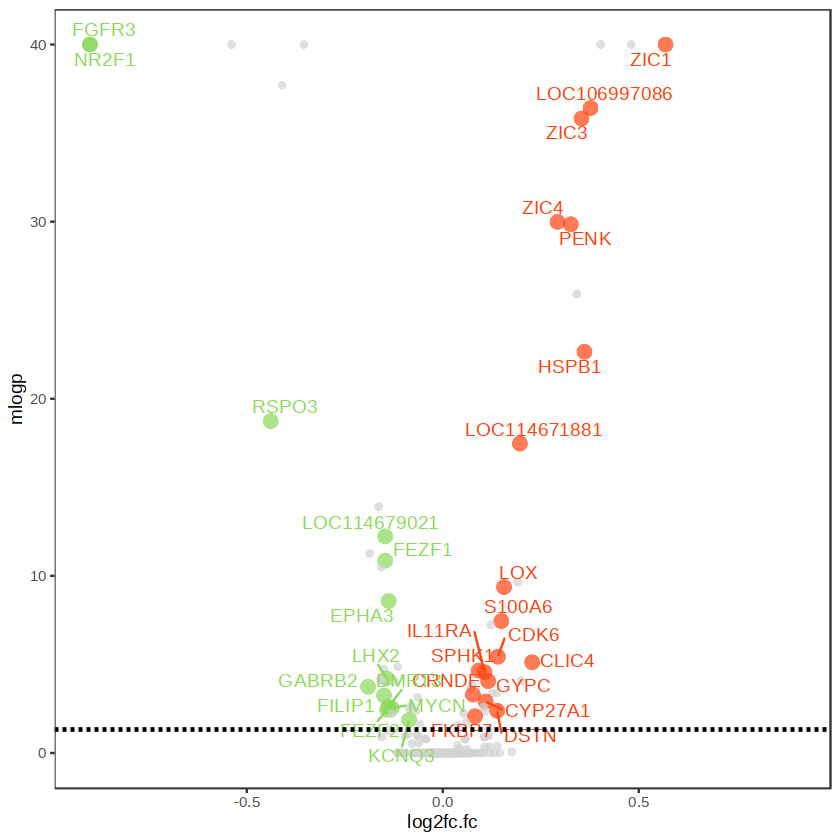

In [8]:
## Visualize the results
reg_genes <- ExtractType1DEGs(res = deres, nsc_cls = "NSC")
reg_genes[["FC"]] <- intersect(reg_genes[["FC"]], type1_genes[["FC"]])
reg_genes[["OC"]] <- intersect(reg_genes[["OC"]], type1_genes[["OC"]])
p1 <- PlotDot(data = deres, frontal_label = reg_genes[["FC"]], 
             occipital_label = reg_genes[["OC"]], 
              x_range = xaxis_limits, y_range = yaxis_limits)
options(repr.plot.width = 7, repr.plot.height = 7)
p1

In [9]:
## Venn diagram illustrating the overlap of region-specific genes between in vitro and in vivo

## Obtain the full list of in vivo DEGs
full_invivo <- list(FC = ExtractFullRegionMarkers(subset(early, subcls_abbr %in% "NSC"), 
                                                  ident.1 = "FC", ident.2 = "OC"),
                    OC = ExtractFullRegionMarkers(subset(early, subcls_abbr %in% "NSC"), 
                                                  ident.1 = "OC", ident.2 = "FC"))

sapply(full_invivo, length)

## QC
sum(reg_genes[["FC"]] %in% full_invivo[["FC"]])
length(reg_genes[["FC"]])
sum(reg_genes[["OC"]] %in% full_invivo[["OC"]])
length(reg_genes[["OC"]])

## Merge
full_invivo[["FC"]] <- union(full_invivo[["FC"]], reg_genes[["FC"]])
full_invivo[["OC"]] <- union(full_invivo[["OC"]], reg_genes[["OC"]])

FC  OC 
154 106

[1] 12

[1] 18

[1] 8

[1] 13

Loading required package: grid



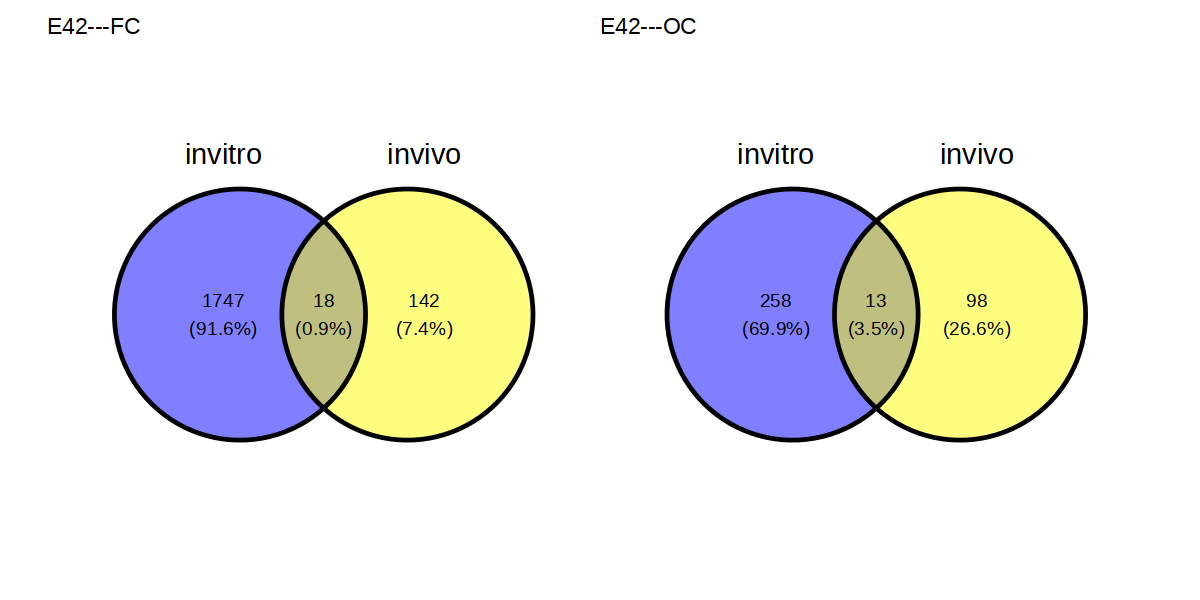

In [10]:
## How do the in vivo and in vitro DEGs are overlapped
library(ggvenn)
plist <- list()
for (reg in c("FC", "OC")){
    sublist <- list(invitro = genelist[[paste0(ag, "_", reg, "_early")]],
                   invivo = full_invivo[[reg]])
    plist[[paste0(ag, "_", reg)]] <- ggvenn(sublist) +
            labs(title = paste0(ag, "---", reg))
}

options(repr.plot.width = 10, repr.plot.height = 5)
p <- patchwork::wrap_plots(plist, nrow = 1, ncol = 2)
p

In [11]:
## Analysis for late cells
ag <- "E77"
type1_genes <- lapply(c("FC", "OC"), function(reg) genelist[[paste0(ag, "_", reg, "_early")]]) %>%
    setNames(., c("FC", "OC"))

## Check the regional enrichment of all these genes
genes <- unlist(type1_genes) %>% unique() %>%
            intersect(., rownames(late))

late$subcls_abbr <- gsub("dorsal NSC", "NSC", late$subclass)
deres <- FindRegionMarkers(object = subset(late, subcls_abbr %in% "NSC"), genes_use = genes,
                          x_range = xaxis_limits, y_range = yaxis_limits) %>%
            mutate(cluster = "NSC")

In [12]:
fc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "early" & 
                               submeta$region %in% "FC"]
oc.points <- rownames(submeta)[submeta$age %in% ag & 
                               submeta$period %in% "early" & 
                               submeta$region %in% "OC"]
## inconsistent regional enrichment between in vitro and in vivo
subrpkm[c("PENK", "VIM", "C1QL1", "CHST1", "LUZP2", "SLC15A2"), c(fc.points, oc.points)]

,RM_1F_77,RM_2F_77,RM_3F_77,RM_1C_77,RM_2C_77,RM_3C_77
PENK,2.5772,16.9875,23.5089,1.6215,1.4927,2.5232
VIM,1747.1130,1423.3518,1537.8807,702.8233,559.4063,814.0804
C1QL1,75.0489,69.6068,76.8368,25.4075,34.2489,37.3795
CHST1,4.8395,5.7224,6.7820,24.8431,27.5362,32.0888
LUZP2,0.4335,0.2264,0.3076,2.2430,1.6026,2.1641
SLC15A2,6.1742,6.9516,6.5402,13.3517,12.8906,15.4644


Warning message:
“Removed 1083 rows containing missing values (`geom_text_repel()`).”


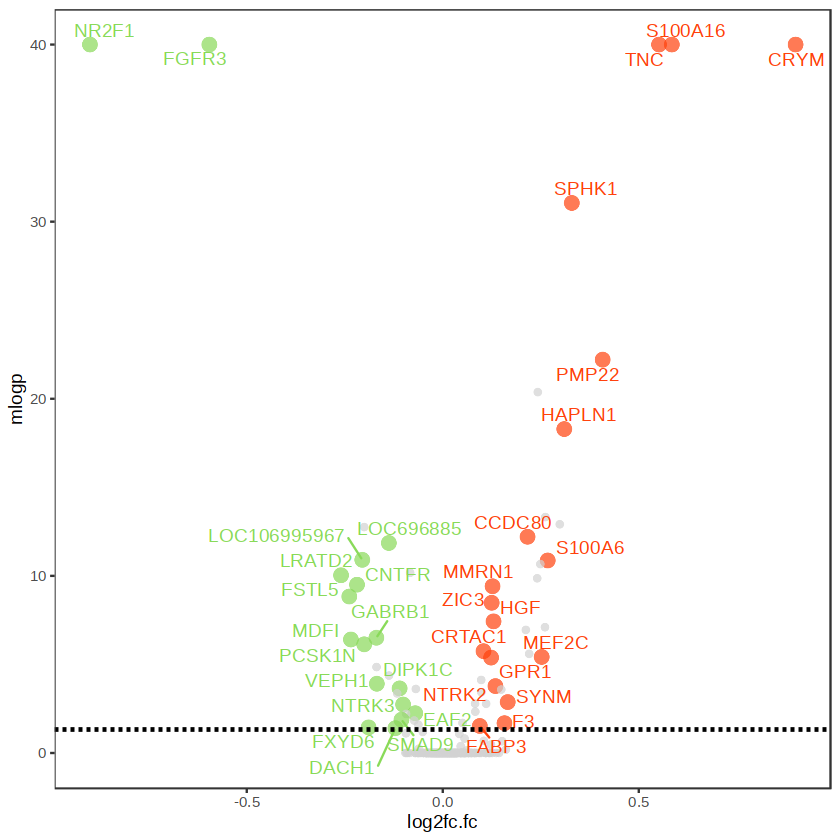

In [13]:
## Visualize the results
reg_genes <- ExtractType1DEGs(res = deres, nsc_cls = "NSC")
reg_genes[["FC"]] <- intersect(reg_genes[["FC"]], type1_genes[["FC"]])
reg_genes[["OC"]] <- intersect(reg_genes[["OC"]], type1_genes[["OC"]])
p2 <- PlotDot(data = deres, frontal_label = reg_genes[["FC"]], 
             occipital_label = reg_genes[["OC"]],
             x_range = xaxis_limits, y_range = yaxis_limits)
options(repr.plot.width = 7, repr.plot.height = 7)
p2

Warning message:
“Removed 1983 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 1083 rows containing missing values (`geom_text_repel()`).”


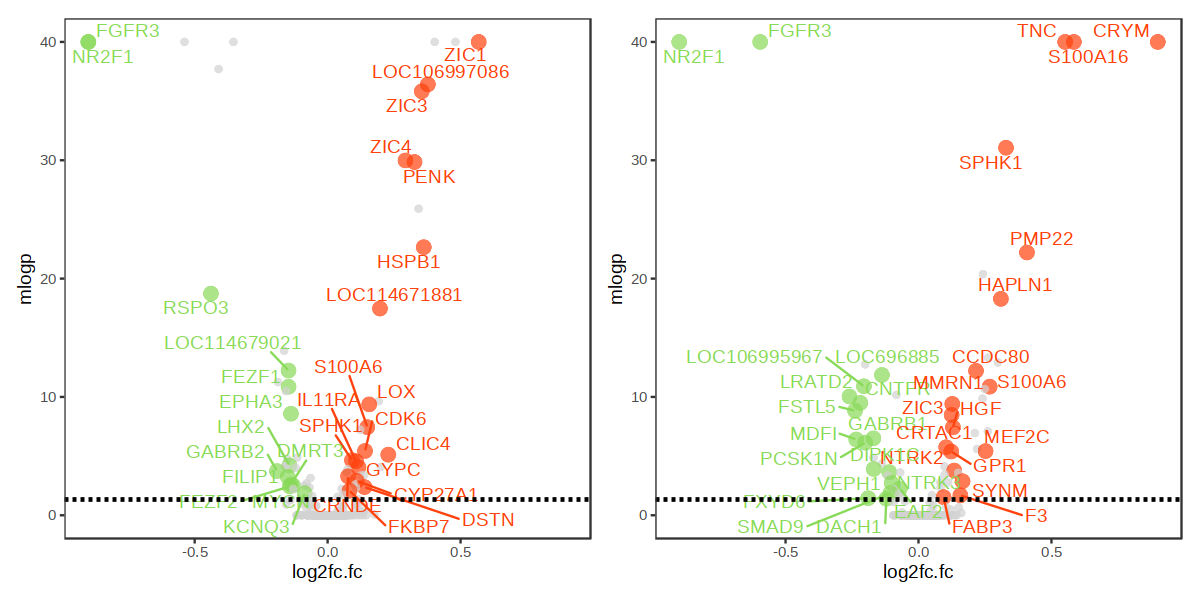

In [14]:
newp <- patchwork::wrap_plots(list(p1, p2), nrow = 1, ncol = 2, widths = c(1, 1))
options(repr.plot.width=10, repr.plot.height=5)
newp

In [15]:
pdf(paste0("./report/Show_BulkDEG_DEGs-NSC_in_vivo_combined_dots_v1.pdf"), 
    width = 11, height = 5, useDingbats = FALSE)
print(newp)
dev.off()

Warning message:
“Removed 1983 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 1083 rows containing missing values (`geom_text_repel()`).”


png 
  2

In [16]:
## Venn diagram illustrating the overlap of region-specific genes between in vitro and in vivo

## Obtain the full list of in vivo DEGs
full_invivo <- list(FC = ExtractFullRegionMarkers(subset(late, subcls_abbr %in% "NSC"), 
                                                  ident.1 = "FC", ident.2 = "OC"),
                    OC = ExtractFullRegionMarkers(subset(late, subcls_abbr %in% "NSC"), 
                                                  ident.1 = "OC", ident.2 = "FC"))

sapply(full_invivo, length)

## QC
sum(reg_genes[["FC"]] %in% full_invivo[["FC"]])
length(reg_genes[["FC"]])
sum(reg_genes[["OC"]] %in% full_invivo[["OC"]])
length(reg_genes[["OC"]])

## Merge
full_invivo[["FC"]] <- union(full_invivo[["FC"]], reg_genes[["FC"]])
full_invivo[["OC"]] <- union(full_invivo[["OC"]], reg_genes[["OC"]])

FC  OC 
180 818

[1] 12

[1] 18

[1] 12

[1] 17

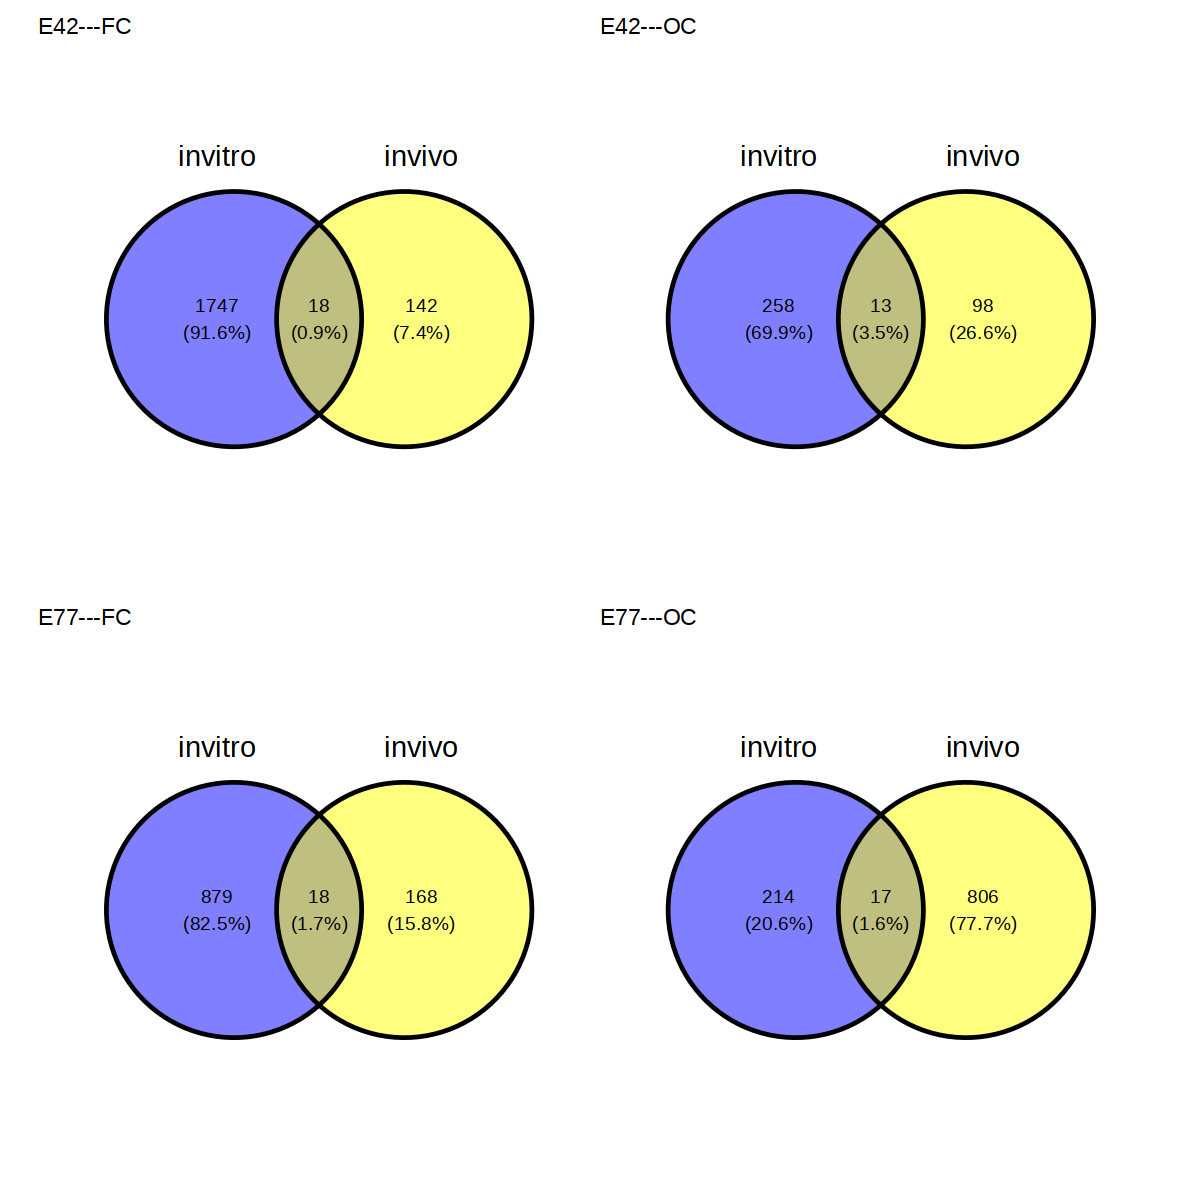

In [17]:
## How do the in vivo and in vitro DEGs are overlapped
for (reg in c("FC", "OC")){
    sublist <- list(invitro = genelist[[paste0(ag, "_", reg, "_early")]],
                   invivo = full_invivo[[reg]])
    plist[[paste0(ag, "_", reg)]] <- ggvenn(sublist) +
            labs(title = paste0(ag, "---", reg))
}

options(repr.plot.width = 10, repr.plot.height = 10)
p <- patchwork::wrap_plots(plist, nrow = 2, ncol = 2)
p

In [18]:
pdf(paste0("./report/Show_BulkDEG_DEGs-NSC_in_vivo_venn.pdf"), 
    width = 11, height = 11, useDingbats = FALSE)
print(p)
dev.off()

png 
  2

In [19]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggvenn_0.1.9       ggplot2_3.4.1      dplyr_1.1.0        SeuratObject_4.1.3
[5] Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] ggbeeswarm_0.7.1       R